# Safari Challenge Solution (TensorFlow)

In this challenge, you must use what you've learned to train a convolutional neural network model that classifies images of animals you might find on a safari adventure.

## Explore the data

The training images you must use are in the **/safari/training** folder. Run the cell below to see an example of each image class, and note the shape of the images (which indicates the dimensions of the image and its color channels).

In [1]:
!wget -P data https://github.com/iliyaML/datasets/raw/main/safari.zip

--2022-11-05 08:49:53--  https://github.com/iliyaML/datasets/raw/main/safari.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/iliyaML/datasets/main/safari.zip [following]
--2022-11-05 08:49:53--  https://raw.githubusercontent.com/iliyaML/datasets/main/safari.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132066 (1.1M) [application/zip]
Saving to: 'data/safari.zip'

     0K .......... .......... .......... .......... ..........  4% 1.81M 1s
    50K .......... .......... .......... .......... ..........  9% 1.93M 1s
   100K .......... .......... .......... .......... .......... 13% 6.

In [2]:
import os
import zipfile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow import convert_to_tensor

print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

RANDOM_STATE = 42
# Set random seed for reproducability
tf.random.set_seed(RANDOM_STATE)

TensorFlow version: 2.5.0
Keras version: 2.5.0


In [3]:
# Extract zip file
with zipfile.ZipFile('data/safari.zip', 'r') as zip_ref:
    zip_ref.extractall('data/safari')

4 classes:
['elephant', 'giraffe', 'lion', 'zebra']


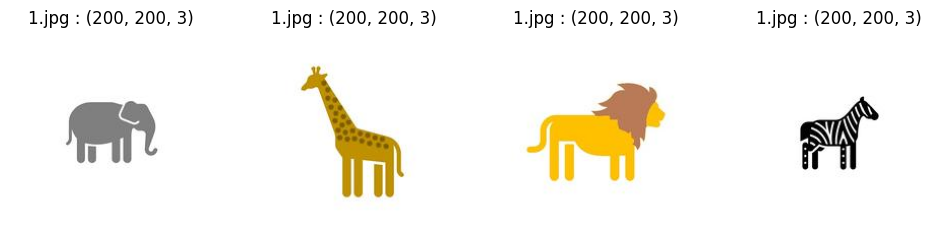

In [4]:
# The images are in the data/shapes folder
data_path = 'data/safari/training'

# Get the class names
classes_ls = os.listdir(data_path)
classes_ls.sort()
print(len(classes_ls), 'classes:')
print(classes_ls)

# Show the first image in each folder
fig = plt.figure(figsize=(12, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes_ls),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

Now that you've seen the images, use your preferred framework (PyTorch or TensorFlow) to train a CNN classifier for them. Your goal is to train a classifier with a validation accuracy of 95% or higher.

### Install and import TensorFlow

In [5]:
# !pip install --upgrade tensorflow

### Create data generators

In [6]:
img_size = (200,200)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 280 images belonging to 4 classes.
Preparing validation dataset...
Found 116 images belonging to 4 classes.
Data generators ready


### Define the CNN

In [7]:
# Define a CNN classifier network

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 195, 32)      3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 32)        0

### Train the model

In [8]:
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
9/9 [==============================] - 33s 3s/step - loss: 1.3451 - accuracy: 0.2920 - val_loss: 1.0224 - val_accuracy: 0.3667
Epoch 2/5
9/9 [==============================] - 24s 3s/step - loss: 0.9407 - accuracy: 0.5720 - val_loss: 0.5577 - val_accuracy: 0.9444
Epoch 3/5
9/9 [==============================] - 18s 2s/step - loss: 0.4447 - accuracy: 0.8760 - val_loss: 0.1291 - val_accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 18s 2s/step - loss: 0.2642 - accuracy: 0.9120 - val_loss: 0.1174 - val_accuracy: 0.9889
Epoch 5/5
9/9 [==============================] - 29s 3s/step - loss: 0.0447 - accuracy: 0.9889 - val_loss: 0.0058 - val_accuracy: 1.0000


### View the loss history

Check for overfitting.

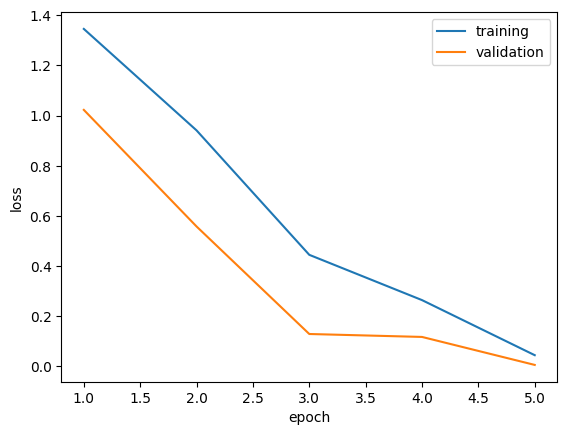

In [9]:
epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate model performance

Generating predictions from validation data...


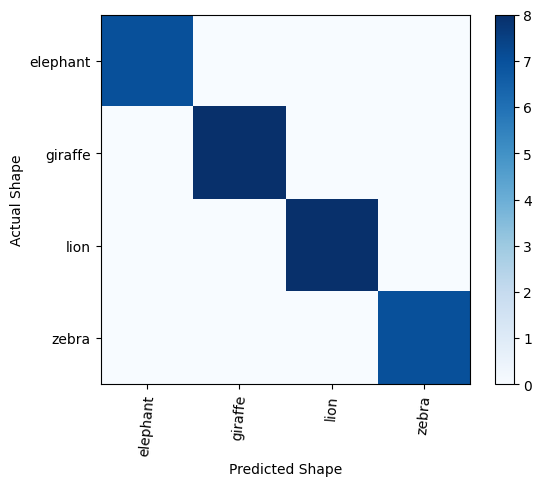

In [10]:
print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
X_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(X_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Save your model

Add code below to save your model's trained weights.

In [11]:
# Save the trained model
modelFileName = 'animal_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as animal_classifier.h5


## Use the trained model

Now that we've trained your model,modify the following code as necessary to use it to predict the classes of the provided test images.

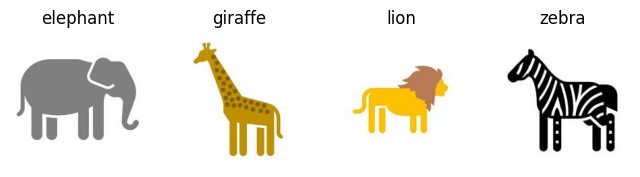

In [12]:
# Function to predict the class of an image
def predict_image(classifier, image):
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index


# Load your model
loaded_model = models.load_model(modelFileName) # loads the saved model

# The images are in the data/shapes folder
test_data_path = 'data/safari/test'

# Show the test images with predictions
fig = plt.figure(figsize=(8, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(loaded_model, np.array(img))
    a=fig.add_subplot(1, len(classes_ls),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes_ls[index])
plt.show()

Hopefully, your model predicted all four of the image classes correctly!